# Importar TensorFlow e Bibliotecas necessárias

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import time
import numpy as np

import os
import pathlib
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import csv

import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

import collections

# Load Dataset no Google Drive

In [1]:
# ESTA CÉLULA NÃO DEVE SER EXECUTADA FORA DO GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

!tar -xvzf drive/MyDrive/cartoonset100k.tgz -C ./
#!tar -xvzf cartoonset100k.tgz -C ./
!pip install tensorflow-addons

A saída de streaming foi truncada nas últimas 5000 linhas.
cartoonset100k/9/cs9808594052212514907.png
cartoonset100k/9/cs9250643729143446375.csv
cartoonset100k/9/cs8790863395645859297.csv
cartoonset100k/9/cs9097565075997015081.csv
cartoonset100k/9/cs9537491702349003253.csv
cartoonset100k/9/cs9624856437525185872.csv
cartoonset100k/9/cs9330117103065842320.png
cartoonset100k/9/cs8540450803658174656.png
cartoonset100k/9/cs8594306646305764027.png
cartoonset100k/9/cs8775448635667048237.png
cartoonset100k/9/cs8781119241599391206.png
cartoonset100k/9/cs9088420412983075427.png
cartoonset100k/9/cs93560745640150534.csv
cartoonset100k/9/cs9594632064452157637.png
cartoonset100k/9/cs8924883961303801149.csv
cartoonset100k/9/cs9078052680738825839.png
cartoonset100k/9/cs9271445432452978534.csv
cartoonset100k/9/cs8524575457407860888.csv
cartoonset100k/9/cs9858031603732095488.png
cartoonset100k/9/cs9293122657500154751.png
cartoonset100k/9/cs8524139019521509918.csv
cartoonset100k/9/cs9788759930761528200.p

# Funções Auxiliares

In [2]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    latent = enc(test_input, training=False)
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('drive/MyDrive/ae/cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    #plt.savefig('ae/cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

# Configurações

In [3]:
img_height, img_width = 256, 256
batch_size = 128

# Carregar Dataset

Dataset: https://google.github.io/cartoonset/

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'cartoonset100k',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 100000 files belonging to 1 classes.


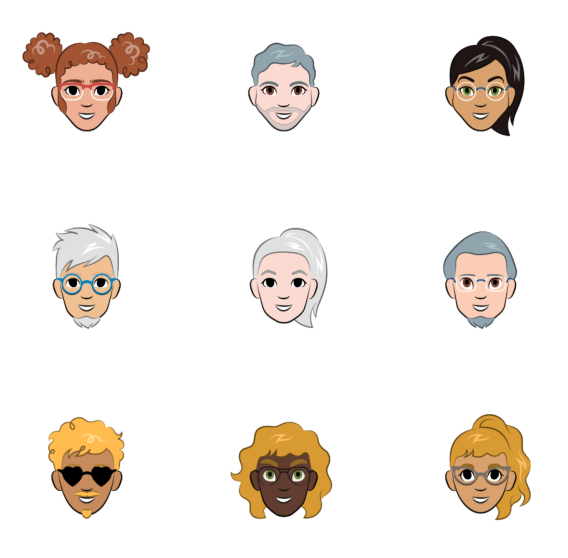

In [7]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [9]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [10]:
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

# Definir Encoder

In [12]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
   
    
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(200, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [13]:
enc = encoder(input_encoder)

In [14]:
enc.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 128, 128, 32)      128       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 64, 64, 64)        256       
_________________________________________________________________
lrelu_2 (LeakyReLU)          (None, 64, 64, 64)        0   

# Definir Decoder

In [15]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    #x = tf.reshape(x, [-1, 8, 8, 64], name='Reshape_Layer')
    x = layers.Reshape((8,8,64), name='Reshape_Layer')(x)
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  
    
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
  
    
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [16]:
dec = decoder(input_decoder)

In [17]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
Reshape_Layer (Reshape)      (None, 8, 8, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 32, 32, 64)        3692

# Optimizer e função de Loss

In [18]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
def ae_loss(y_true, y_pred):
    #loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    #loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred)))
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

# Treinar o dataset

In [20]:
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = ae_loss(images, generated_images)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [21]:
os.makedirs('drive/MyDrive/ae/cartoon/training_weights', exist_ok=True)
os.makedirs('drive/MyDrive/ae/cartoon/images', exist_ok=True)
#os.makedirs('ae/cartoon/training_weights', exist_ok=True)
#os.makedirs('ae/cartoon/images', exist_ok=True)

In [22]:

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        print ('Start epoch {}'.format(epoch + 1))
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('drive/MyDrive/ae/cartoon/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('drive/MyDrive/ae/cartoon/training_weights/dec_'+ str(epoch)+'.h5')
        #enc.save_weights('ae/cartoon/training_weights/enc_'+ str(epoch)+'.h5')
        #dec.save_weights('ae/cartoon/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,dec],
                            epochs,
                            seed)

In [ ]:
train(normalized_ds, 25)

# Load dos pesos

In [ ]:
enc.load_weights('drive/MyDrive/ae/cartoon/training_weights/enc_24.h5')

In [ ]:
dec.load_weights('drive/MyDrive/ae/cartoon/training_weights/dec_24.h5')

# Criação de Cartoons

In [30]:
reconstruction = None
lat_space = None
it = 0
for i in normalized_ds:
    if it == 26:
      break
    latent= enc.predict(i)
    out = dec.predict(latent)
    it += 1
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

In [31]:
reconstruction.shape

(3328, 256, 256, 3)

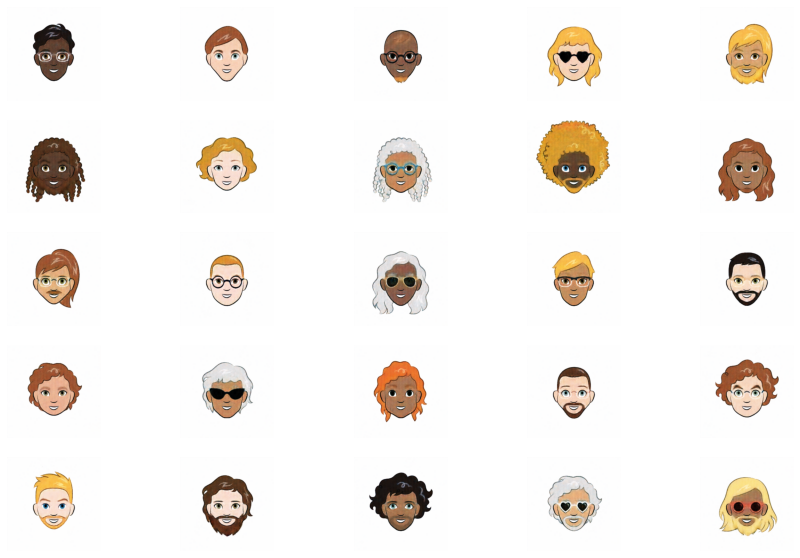

In [32]:
figsize = 15

fig = plt.figure(figsize=(figsize, 10))
#fig.subplots_adjust(hspace=0.2, wspace=None)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)